In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: NVIDIA L4


In [2]:
from google.colab import files
uploaded = files.upload()

Saving RRAVIPRA_val_final_5%.csv to RRAVIPRA_val_final_5%.csv
Saving RRAVIPRA_test_final_5%.csv to RRAVIPRA_test_final_5%.csv
Saving RRAVIPRA_train_final_5%.csv to RRAVIPRA_train_final_5%.csv


In [3]:
import pandas as pd
train_df = pd.read_csv('RRAVIPRA_train_final_5%.csv')
test_df = pd.read_csv('RRAVIPRA_test_final_5%.csv')
val_df = pd.read_csv('RRAVIPRA_val_final_5%.csv')

In [4]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
class ToxicCommentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.text = data['message']
        self.targets = data['label']
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text.iloc[idx])
        target = self.targets.iloc[idx]

        # Preparing the text input for T5 format
        input = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        target = torch.tensor(target, dtype=torch.long)

        return {
            'input_ids': input['input_ids'].flatten(),
            'attention_mask': input['attention_mask'].flatten(),
            'labels': target
        }

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
max_length = 512  # Adjust based on your dataset specifics and limitations

train_dataset = ToxicCommentDataset(train_df, tokenizer, max_length)
val_dataset = ToxicCommentDataset(val_df, tokenizer, max_length)
test_dataset = ToxicCommentDataset(test_df, tokenizer, max_length)  # New test dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)  # DataLoader for testing

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
from transformers import T5ForConditionalGeneration, T5Config
import torch
import torch.nn as nn

class T5ForBinaryClassification(nn.Module):
    def __init__(self, model_name='t5-small', num_labels=2):
        super(T5ForBinaryClassification, self).__init__()
        self.num_labels = num_labels
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        # Assuming we are using the encoder's output dimension
        self.classifier = nn.Linear(self.model.encoder.embed_tokens.embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get the encoder outputs
        outputs = self.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # The last hidden state is the first output
        sequence_output = outputs.last_hidden_state[:, 0, :]  # Use the embeddings of the first token (<s> token)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return loss, logits

In [11]:
def compute_accuracy(logits, labels):
    # Convert logits to predicted labels
    predictions = torch.argmax(logits, dim=-1)
    correct_predictions = torch.eq(predictions, labels).float()  # Element-wise comparison
    accuracy = correct_predictions.sum() / labels.numel()  # Calculate accuracy
    return accuracy.item()  # Return the accuracy as a Python float

In [8]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score

def evaluate_model3(model, data_loader, device):
    model.eval()
    total_accuracy = 0
    all_predictions = []
    all_probabilities = []  # Store probabilities for ROC-AUC
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get the model output logits
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            total_accuracy += compute_accuracy(predictions, labels)

            # Use softmax to get probabilities
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            all_probabilities.extend(probabilities.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = total_accuracy / len(data_loader)

    # Use None to get scores for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    cm = confusion_matrix(all_labels, all_predictions)

    # Calculate ROC-AUC score for each class
    rocauc_scores = []
    for i in range(model.num_labels):  # Assuming model.num_labels contains the number of classes
        # Calculate ROC-AUC for each class
        # For each class, treat it as the positive class and the rest as the negative class
        binary_labels = [1 if label == i else 0 for label in all_labels]
        binary_probabilities = [prob[i] for prob in all_probabilities]
        rocauc_score = roc_auc_score(binary_labels, binary_probabilities)
        rocauc_scores.append(rocauc_score)

    return accuracy, precision, recall, f1, cm, rocauc_scores, all_labels, all_predictions, all_probabilities

In [9]:
from transformers import T5ForConditionalGeneration, T5Config
import torch
import torch.nn as nn

class T5ForBinaryClassification(nn.Module):
    def __init__(self, model_name='t5-small', num_labels=2):
        super(T5ForBinaryClassification, self).__init__()
        self.num_labels = num_labels
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        # Assuming we are using the encoder's output dimension
        self.classifier = nn.Linear(self.model.encoder.embed_tokens.embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get the encoder outputs
        outputs = self.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # The last hidden state is the first output
        sequence_output = outputs.last_hidden_state[:, 0, :]  # Use the embeddings of the first token (<s> token)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return loss, logits

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 8866/8866 [1:06:24<00:00,  2.23it/s]


Epoch 1, Training Loss: 0.06652223067549316
Epoch 1, Validation - Accuracy: 0.7068585526315789, Precision: [0.99865265 0.10995542], Recall: [0.99012138 0.47741935], F1: [0.99436872 0.17874396], ROC-AUC: [0.8950533484845582, 0.8950537208812395]


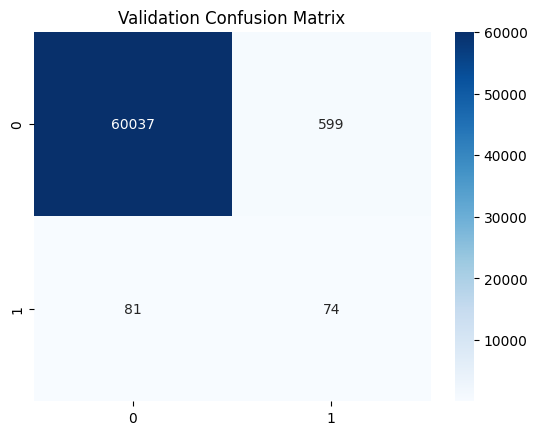

Epoch 1, Test - Accuracy: 0.7301644736842106, Precision: [0.99866997 0.11682243], Recall: [0.99064912 0.48387097], F1: [0.99464337 0.18820577], ROC-AUC: [0.9127650134382002, 0.9127648538396225]


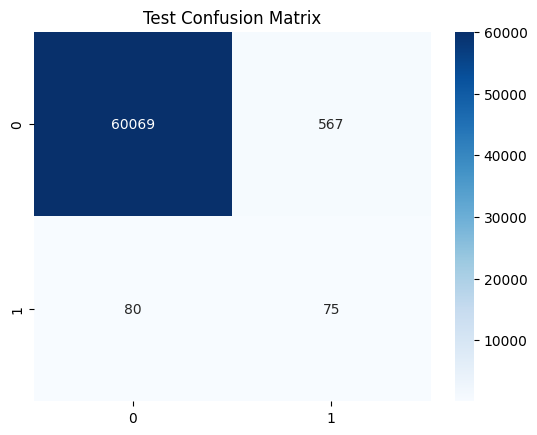

100%|██████████| 8866/8866 [1:06:25<00:00,  2.22it/s]


Epoch 2, Training Loss: 0.03414123507127863
Epoch 2, Validation - Accuracy: 0.7431907894736842, Precision: [0.99873769 0.13527397], Recall: [0.99167161 0.50967742], F1: [0.99519211 0.21380244], ROC-AUC: [0.914558103458182, 0.9145583694558115]


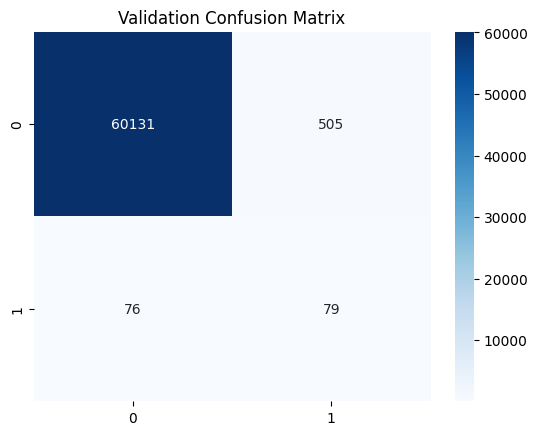

Epoch 2, Test - Accuracy: 0.7453618421052631, Precision: [0.99868775 0.12903226], Recall: [0.99153968 0.49032258], F1: [0.99510088 0.20430108], ROC-AUC: [0.9315793981644036, 0.9315795045634553]


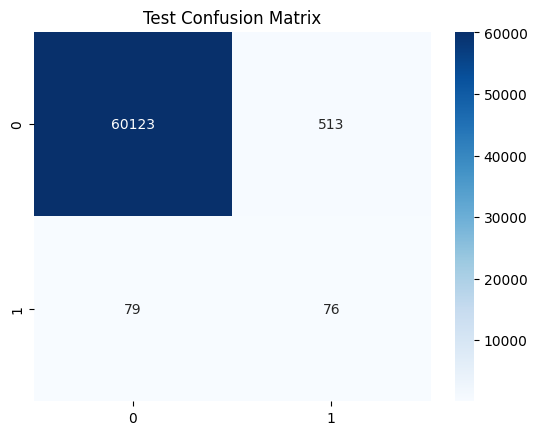

100%|██████████| 8866/8866 [1:06:25<00:00,  2.22it/s]


Epoch 3, Training Loss: 0.026629415380480866
Epoch 3, Validation - Accuracy: 0.8319736842105263, Precision: [0.99872571 0.21369863], Recall: [0.99526684 0.50322581], F1: [0.99699328 0.3       ], ROC-AUC: [0.9353783763079105, 0.9353804510894199]


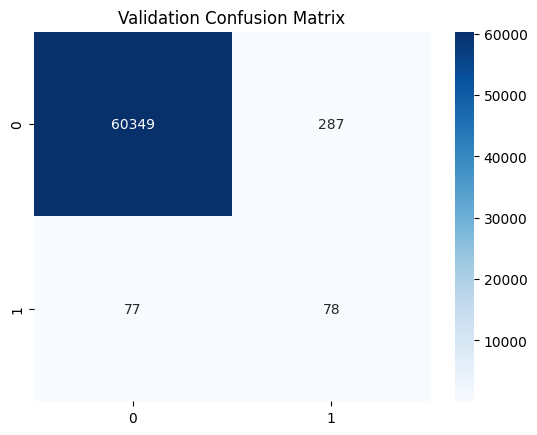

Epoch 3, Test - Accuracy: 0.8251809210526316, Precision: [0.9986921  0.19537275], Recall: [0.99483805 0.49032258], F1: [0.99676135 0.27941176], ROC-AUC: [0.9536316124350699, 0.9536315592355441]


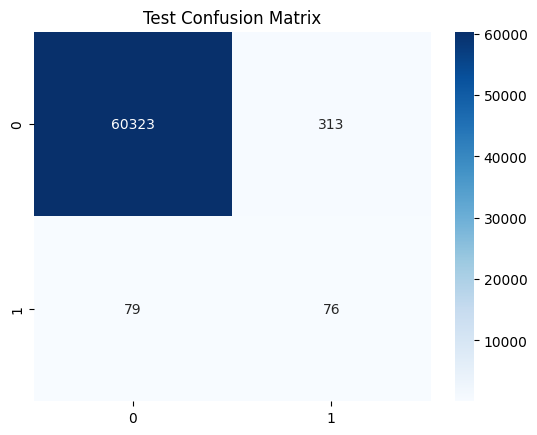

In [12]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

val_errors = []
test_errors = []

model = T5ForBinaryClassification('t5-small').to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    # Training phase
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss if hasattr(outputs, 'loss') else outputs[0]
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs[1]

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}')

    # Validation phase
    val_accuracy, val_precision, val_recall, val_f1, val_cm, val_rocauc, val_all_labels, val_all_predictions, val_all_probabilities = evaluate_model3(model, val_loader, device)
    val_error = 1 - val_accuracy
    val_errors.append(val_error)
    print(f'Epoch {epoch+1}, Validation - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, ROC-AUC: {val_rocauc}')
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Validation Confusion Matrix')
    plt.show()

    # Test phase
    test_accuracy, test_precision, test_recall, test_f1, test_cm, test_rocauc, test_all_labels, test_all_predictions, test_all_probabilities = evaluate_model3(model, test_loader, device)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)
    print(f'Epoch {epoch+1}, Test - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}, ROC-AUC: {test_rocauc}')
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.show()

In [13]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming all_labels and all_predictions are available

# Generate a classification report
# At the end of your training script, when evaluating on the test set
test_accuracy, test_precision, test_recall, test_f1, test_cm, test_rocauc, test_all_labels, test_all_predictions, test_all_probabilities = evaluate_model3(model, test_loader, device)

              precision    recall  f1-score   support

   Non-Toxic       1.00      0.99      1.00     60636
       Toxic       0.20      0.49      0.28       155

    accuracy                           0.99     60791
   macro avg       0.60      0.74      0.64     60791
weighted avg       1.00      0.99      0.99     60791



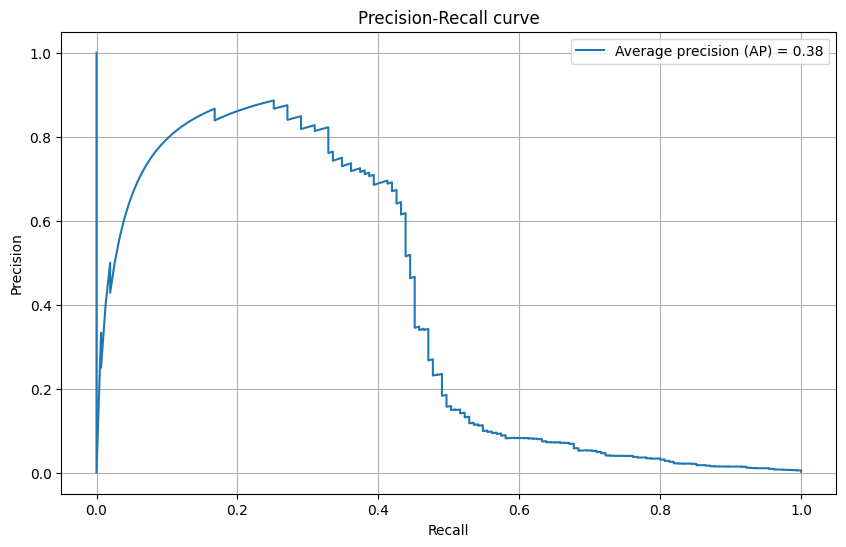

In [14]:
print(classification_report(test_all_labels, test_all_predictions, target_names=['Non-Toxic', 'Toxic'])) # Update target_names as per your classes

# For the precision-recall curve, you need probabilities. Assuming all_probabilities is available
# Note: This example assumes a binary classification task. For multi-class tasks, you would need to adjust accordingly.

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(test_all_labels, [p[1] for p in test_all_probabilities])

# Calculate average precision score
average_precision = average_precision_score(test_all_labels, [p[1] for p in test_all_probabilities])

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Average precision (AP) = {average_precision:0.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()